In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from keras.layers import Dense, Dropout
from keras.models import Sequential
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.width', 2000)
from keras.optimizers import SGD
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion

import keras
from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import import_ipynb
from Helpers import *
from PandasFeatureUnion import PandasFeatureUnion

Using TensorFlow backend.


importing Jupyter notebook from Helpers.ipynb
importing Jupyter notebook from PandasFeatureUnion.ipynb


/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv',index_col='Id')
test_ids = test.index
y_train = np.log(train['SalePrice'])
np.random.seed(1)

total_bath= lambda x: x.FullBath+x.HalfBath*0.5 +x.BsmtHalfBath*0.5+x.BsmtFullBath


bath_columns = ['FullBath','HalfBath','BsmtHalfBath', 'BsmtFullBath']
bath_pipeline = Pipeline([
    ('SelectBathColumns',  ColumnSelector(columns=bath_columns)),
    ('fillNaAsZero', FillNA(columns=bath_columns, fill_value=0)),
    ('combine', ApplyTransformer(fn=total_bath, name='Bath')),
  #  ('drop',DropColumns(columns=bath_columns))
]) 
  

important_columns = [
    'GrLivArea', 'YearBuilt', 'OverallQual','MSSubClass',
    'Neighborhood', 'SaleType', 'BldgType','LotFrontage','GarageCars',
    'PoolQC'
]
# No improovement
# 'BldgType' 

cs = ColumnSelector(columns=important_columns)

scdt = DummiesTransformer(column='MSSubClass', keys=[ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 150, 160, 180, 190])
oqdt = DummiesTransformer(column='OverallQual', keys=range(1,11))
neigbTrans = DummiesTransformer(column='Neighborhood', keys=["Blmngtn", "Blueste", "BrDale", "BrkSide", "ClearCr", "CollgCr", "Crawfor", "Edwards", "Gilbert", "IDOTRR", "MeadowV", "Mitchel", "Names", "NoRidge", "NPkVill", "NridgHt", "NWAmes", "OldTown", "SWISU", "Sawyer", "SawyerW", "Somerst", "StoneBr", "Timber", "Veenker"])
bdTypeTrans= DummiesTransformer(column='BldgType', keys=['1Fam' ,'TwnhsE', 'Twnhs', 'Duplex', '2fmCon'])
saleTypeTrans= DummiesTransformer(column='SaleType', keys=["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"])

core_pipeline = Pipeline(
    [('SelectColumns', cs),
     ('DummiesMSSubClass', scdt),
     ('OverallQual', oqdt),
     ('DummiesNeighborhood', neigbTrans),
     ('DummiesSaleType', saleTypeTrans),
     ('DummiesBldgType',bdTypeTrans),
     ('fillNaAsZero', FillNA(columns=['LotFrontage','GarageCars'], fill_value=0)),
     ('LogLotFrontage', ApplyTransformer(fn=lambda x:np.log1p(x.LotFrontage), name='LotFrontage')),
     ('LogGrLivArea', ApplyTransformer(fn=lambda x:np.log1p(x.GrLivArea), name='GrLivArea')),
     ('PoolQC_Exists', ApplyTransformer(fn=lambda x:0 if (pd.isnull(x['PoolQC'])) else 1, name='PoolQC')),
    ])

pp = PandasFeatureUnion([
    ('bath',bath_pipeline),
    ('core', core_pipeline)], n_jobs=None)

X_train = pp.fit_transform(train)
X_test = pp.transform(test)
 
 

/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [3]:
# define model
# cc=keras.constraints.MinMaxNorm(min_value=0.0, max_value=2.0, rate=1, axis=0)
model = Sequential()
input_layer = Dense(50, 
#                     kernel_constraint=cc,
#                     kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#                     bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
                    input_dim=len(X_train.columns), 
                    activation='relu', 
                    kernel_initializer='normal') 
model.add(input_layer)

model.add(Dense(50, activation='relu', kernel_initializer='normal') )
# model.add(Dropout(rate=0.05))
model.add(Dense(1, activation='linear'))

optimizer = keras.optimizers.SGD() #Adam(lr=0.0015);
# compile model
model.compile(loss='mean_squared_error', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch
Epoch 00171: early stopping
Train Error: 0.134, Test Error: 0.152


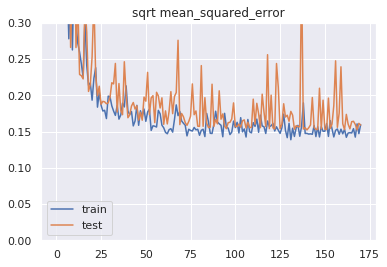

In [4]:

trainX, testX, trainy, testy = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.2, 
                                                    random_state=1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(trainX)
trainX= scaler.transform(trainX)
testX= scaler.transform(testX)
testData = X_test
X_test=scaler.transform(X_test)
# fit model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=30, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
tb_callback =keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
history = model.fit(trainX, trainy, validation_data=(testX, testy), 
                    epochs=3000, verbose=0, batch_size=32, callbacks=[early_stop, tb_callback])

drawTFModel(history, model, trainX, trainy, testX, testy)

In [5]:
result = model.predict(X_test)
dfR = pd.DataFrame(test_ids,columns=['Id'])
dfR['SalePrice']=np.exp(result)
dfR.to_csv('predictions.csv',index = None, header=True)

In [6]:
result

array([[11.654022],
       [11.901566],
       [12.019055],
       ...,
       [11.924644],
       [11.726203],
       [12.315386]], dtype=float32)

In [7]:
print(model.get_weights())

[array([[ 0.01394888, -0.02689145, -0.03301327, ...,  0.0504385 ,
        -0.03586978,  0.02454605],
       [ 0.01435381, -0.06075865, -0.07839016, ..., -0.00875873,
        -0.06395224,  0.0181474 ],
       [-0.02032652, -0.0190852 , -0.0627403 , ..., -0.01939439,
         0.01452569, -0.04414636],
       ...,
       [ 0.10935253, -0.07048009,  0.10309798, ..., -0.01200126,
         0.03685319, -0.02209189],
       [-0.00193939,  0.05746742,  0.00868088, ..., -0.06234865,
        -0.06865828,  0.07544877],
       [ 0.07823941,  0.01620015, -0.00863681, ...,  0.05573715,
        -0.12696584,  0.13643457]], dtype=float32), array([ 3.03535253e-01,  2.08919402e-02,  6.13164604e-02,  1.47746459e-01,
       -4.38251160e-03,  6.11698767e-03, -1.40861729e-02,  1.01549812e-01,
        1.25439120e-02, -3.27149646e-05,  5.05092703e-02,  1.23191439e-01,
        1.81741163e-01,  1.92014985e-02, -1.85443033e-02,  2.01083437e-01,
        1.55166790e-01,  1.63386874e-02, -3.67051773e-02, -1.32975646e

In [8]:
df=train

In [9]:
testData.describe().T['mean']

FullBath                   1.570939
HalfBath                   0.377656
BsmtHalfBath               0.065113
BsmtFullBath               0.433859
Bath                       2.226182
GrLivArea                  7.254488
YearBuilt               1971.357779
LotFrontage                3.534308
GarageCars                 1.764907
PoolQC                     0.002056
MSSubClass_20              0.372173
MSSubClass_30              0.047978
MSSubClass_40              0.001371
MSSubClass_45              0.004112
MSSubClass_50              0.098012
MSSubClass_60              0.189171
MSSubClass_70              0.046607
MSSubClass_75              0.004798
MSSubClass_80              0.041124
MSSubClass_85              0.019191
MSSubClass_90              0.039068
MSSubClass_120             0.065113
MSSubClass_150             0.000685
MSSubClass_160             0.044551
MSSubClass_180             0.004798
MSSubClass_190             0.021247
OverallQual_1              0.001371
OverallQual_2              0

In [10]:
pd.DataFrame(X_test, columns=testData.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
FullBath,1459.0,0.523646,0.185063,0.000000,0.333333,0.666667,0.666667,1.333333
HalfBath,1459.0,0.188828,0.251508,0.000000,0.000000,0.000000,0.500000,1.000000
BsmtHalfBath,1459.0,0.032557,0.126153,0.000000,0.000000,0.000000,0.000000,1.000000
BsmtFullBath,1459.0,0.144620,0.176842,0.000000,0.000000,0.000000,0.333333,1.000000
Bath,1459.0,0.245236,0.166367,0.000000,0.100000,0.200000,0.400000,1.200000
GrLivArea,1459.0,0.510034,0.111867,0.069807,0.426911,0.514651,0.579705,0.963896
YearBuilt,1459.0,0.719984,0.220218,0.050725,0.586957,0.731884,0.934783,1.000000
LotFrontage,1459.0,0.614727,0.269994,0.000000,0.662098,0.723360,0.759984,0.922411
GarageCars,1459.0,0.441227,0.194264,0.000000,0.250000,0.500000,0.500000,1.250000
PoolQC,1459.0,0.002056,0.045314,0.000000,0.000000,0.000000,0.000000,1.000000


In [11]:
test_ids

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919], dtype='int64', name='Id', length=1459)

In [12]:
testData.index

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919], dtype='int64', name='Id', length=1459)

In [13]:
testData.loc[2577,:]

FullBath                   2.000000
HalfBath                   0.000000
BsmtHalfBath               0.000000
BsmtFullBath               0.000000
Bath                       2.000000
GrLivArea                  7.511525
YearBuilt               1923.000000
LotFrontage                3.931826
GarageCars                 0.000000
PoolQC                     0.000000
MSSubClass_20              0.000000
MSSubClass_30              0.000000
MSSubClass_40              0.000000
MSSubClass_45              0.000000
MSSubClass_50              0.000000
MSSubClass_60              0.000000
MSSubClass_70              1.000000
MSSubClass_75              0.000000
MSSubClass_80              0.000000
MSSubClass_85              0.000000
MSSubClass_90              0.000000
MSSubClass_120             0.000000
MSSubClass_150             0.000000
MSSubClass_160             0.000000
MSSubClass_180             0.000000
MSSubClass_190             0.000000
OverallQual_1              0.000000
OverallQual_2              0

In [14]:
n=lambda x: (1 if (pd.isnull(x)) else 0)

In [15]:
n(np.nan)

1

In [16]:
n(55)

0

In [20]:
n(None)

1

In [19]:
pd.isnull('sss')

False